In [ ]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from itertools import product
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.manifold import TSNE

In [146]:
RANKS = [str(i) for i in range(2,10)] + ['T','J','Q','K','A']
SUITS = ['s','h','c','d']
DECK_DICT = {i:card for i, card in enumerate(product(RANKS,SUITS))}


In [166]:
class CardEmbeddingModel(nn.Module):
    def __init__(self, embedding_dim=2):
        super().__init__()
        self.embedder = nn.Embedding(52, embedding_dim)
        self.suit_classifier = nn.Linear(embedding_dim, 4)
        self.rank_classifier = nn.Linear(embedding_dim, 13)
        
    def forward(self, x):
        x_embed = self.embedder(x)
        suit_logits = self.suit_classifier(x_embed)
        rank_logits = self.rank_classifier(x_embed)
        return rank_logits, suit_logits, x_embed

In [148]:
deck_data = [(i, *card) for i, card in enumerate(product(range(13),range(4)))]
cards = torch.tensor([c[0] for c in deck_data])
ranks = torch.tensor([c[1] for c in deck_data])
suits = torch.tensor([c[2] for c in deck_data])

In [167]:
model = CardEmbeddingModel(embedding_dim=4)
optimizer = torch.optim.SGD(params=model.parameters(), lr=.001)
criterion = nn.CrossEntropyLoss()

In [168]:
epochs = 2_000
rank_losses = []
suit_losses = []
losses = []
for epoch in range(epochs):
    rank_logit, suit_logit, _ = model(cards)
    rank_loss = criterion(rank_logit, ranks)
    suit_loss = criterion(suit_logit, suits)
    tot_loss = rank_loss + suit_loss
    losses.append(tot_loss.item())
    rank_losses.append(rank_loss.item())
    suit_losses.append(suit_loss.item())
    tot_loss.backward()
    optimizer.step()
        

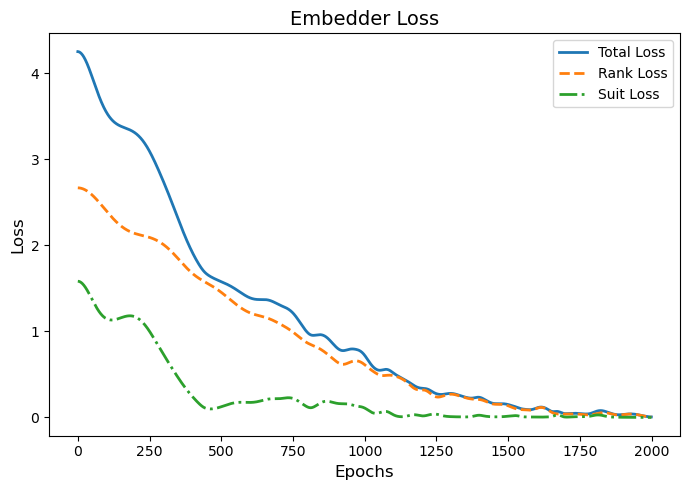

In [169]:
plt.figure(figsize=(7, 5))
sns.lineplot(x=list(range(epochs)), y=losses, label="Total Loss", linestyle='-', linewidth=2)
sns.lineplot(x=list(range(epochs)), y=rank_losses, label="Rank Loss", linestyle='--', linewidth=2)
sns.lineplot(x=list(range(epochs)), y=suit_losses, label="Suit Loss", linestyle='-.', linewidth=2)

plt.title("Embedder Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)

plt.legend(fontsize=10) 
plt.tight_layout()
plt.show()

In [170]:
def compute_accuracy(model, card_indices, ranks, suits):
    with torch.no_grad():
        rank_logits, suit_logits, _ = model(card_indices)
        rank_preds = torch.argmax(rank_logits, dim=1) 
        suit_preds = torch.argmax(suit_logits, dim=1)

        rank_acc = (rank_preds == ranks).float().mean().item()
        suit_acc = (suit_preds == suits).float().mean().item()
    return rank_acc, suit_acc

In [171]:
rank_acc, suit_acc = compute_accuracy(model, cards, ranks, suits)
print('Rank Accuracy: ', rank_acc)
print('Suit Accuracy: ', suit_acc)

Rank Accuracy:  1.0
Suit Accuracy:  1.0


In [172]:
with torch.no_grad():
    learned_embeddings = model.embedder.weight
    print("Learned Card Embeddings:", learned_embeddings)

Learned Card Embeddings: Parameter containing:
tensor([[ -1.4949, -10.2065,  -5.8772,  -0.1640],
        [ -1.6170,   2.8912,   1.0158,   1.4377],
        [-12.7121,  -8.7191,  -2.6823,   4.3460],
        [ -1.2417,  -8.6453,  -9.5184,  -2.6803],
        [ -5.9894,   5.1595,  -8.3461,   1.5301],
        [-12.5110,  14.2425,  -0.4712,   5.3301],
        [ -7.4960,   3.7414,   2.5478,   4.0114],
        [ -1.3197,  -0.6850,  -6.6094,  -3.2505],
        [  5.8330,   7.7653, -10.7596,   5.7420],
        [  4.4591,  12.9857,  -8.7653,   5.4315],
        [ -4.9124,   8.2608,  -6.4998,  15.4026],
        [ 10.7773,   4.9581, -11.3163,  -1.6501],
        [  4.8287,  -2.1909,  -2.5930,  16.2330],
        [  6.0721,   4.6494,   1.0377,  15.4415],
        [ -3.3871,  -6.8588,  -5.6813,  15.4846],
        [  9.4043, -11.9763,  -8.8203,   2.1992],
        [ -6.1803,  -1.3952,  -4.9316,  -5.0738],
        [  0.9022,  19.0311,   2.9259, -18.6476],
        [-14.4416,  -2.9322,  -3.1943, -10.2484],
   

In [173]:
pca = PCA(n_components=3)
z_pca = pca.fit_transform(learned_embeddings.detach().numpy())

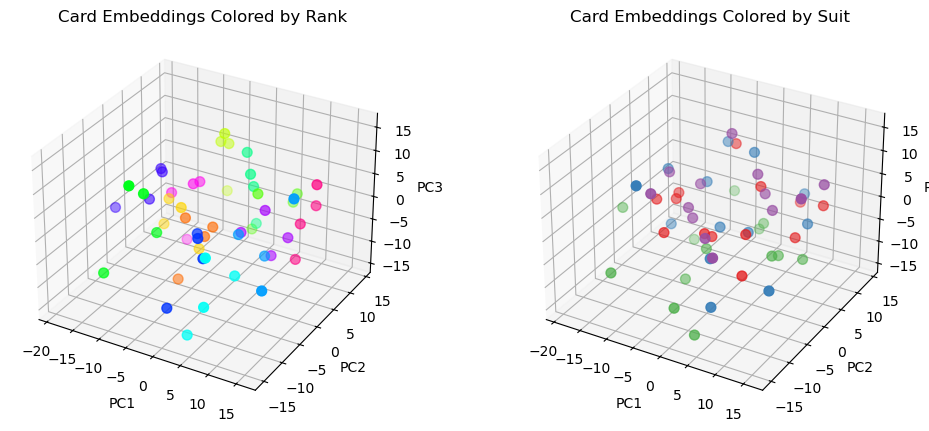

In [174]:
rank_palette = sns.color_palette("hsv", 13)
suit_palette = sns.color_palette("Set1", 4)
rank_colors = [rank_palette[r] for r in ranks]
suit_colors = [suit_palette[s] for s in suits]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(z_pca[:, 0], z_pca[:, 1], z_pca[:, 2], c=rank_colors, s=50)
ax1.set_title("Card Embeddings Colored by Rank")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(z_pca[:, 0], z_pca[:, 1], z_pca[:, 2], c=suit_colors, s=50)
ax2.set_title("Card Embeddings Colored by Suit")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")

plt.show()

In [162]:
tsne = TSNE(n_components=3)
z_tsne = tsne.fit_transform(learned_embeddings.detach().numpy())

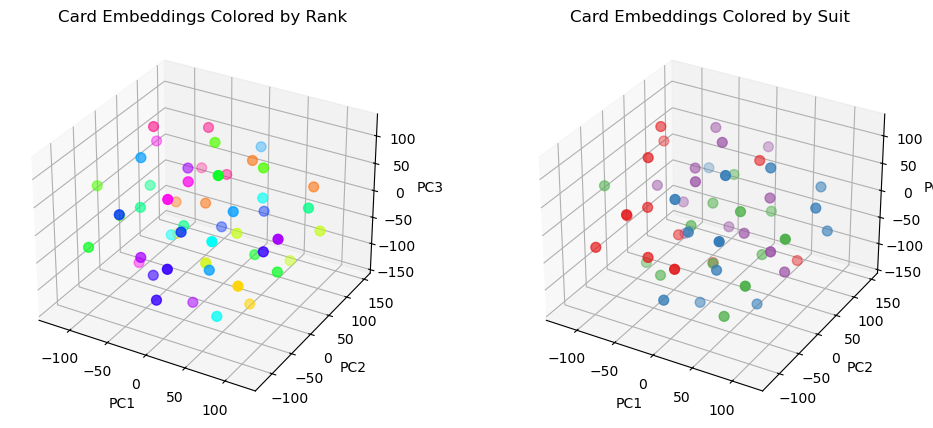

In [175]:
rank_palette = sns.color_palette("hsv", 13)
suit_palette = sns.color_palette("Set1", 4)
rank_colors = [rank_palette[r] for r in ranks]
suit_colors = [suit_palette[s] for s in suits]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(z_tsne[:, 0], z_tsne[:, 1], z_tsne[:, 2], c=rank_colors, s=50)
ax1.set_title("Card Embeddings Colored by Rank")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")


ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(z_tsne[:, 0], z_tsne[:, 1], z_tsne[:, 2], c=suit_colors, s=50)
ax2.set_title("Card Embeddings Colored by Suit")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")

plt.show()

In [183]:
model.embedder.weight[0]

tensor([ -1.4949, -10.2065,  -5.8772,  -0.1640], grad_fn=<SelectBackward0>)

In [194]:
cos = nn.CosineSimilarity(dim=0)
similarity_data = []
for card1, card2 in product(range(52), range(52)):
    with torch.no_grad():
        similarity = cos(model.embedder.weight[card1],model.embedder.weight[card2])
        similarity_data.append({'card1': card1, 'card2': card2, 'similarity': similarity.item()})
similarity_df = pd.DataFrame(similarity_data)

In [195]:
similarity_df['card1'] = similarity_df['card1'].apply(lambda x: DECK_DICT[x])
similarity_df['card2'] = similarity_df['card2'].apply(lambda x: DECK_DICT[x])
similarity_df

,card1,card2,similarity
0,"(2, s)","(2, s)",1.000000
1,"(2, s)","(2, h)",-0.747573
2,"(2, s)","(2, c)",0.638175
3,"(2, s)","(2, d)",0.935051
4,"(2, s)","(3, s)",0.036989
...,...,...,...
2699,"(A, d)","(K, d)",-0.175809
2700,"(A, d)","(A, s)",0.835214
2701,"(A, d)","(A, h)",0.824494
2702,"(A, d)","(A, c)",0.437950
